# EEG Source Localization and SSVEP Analysis: Part 0 - MNE Demo

This notebook provides a comprehensive pipeline for preprocessing EEG data, analyzing Steady-State Visual Evoked Potentials (SSVEP), and performing source localization. The pipeline is designed for reproducibility and modularity, allowing researchers to customize key parameters at each stage. The workflow is built on **MNE-Python**, integrating EEG signal processing techniques and advanced visualization methods.

#### Key Objectives
1. **Preprocess EEG Data**:
   - Load EEG data and apply bandpass filtering to isolate relevant frequency bands.
   - Detect and segment events into epochs for targeted analysis.
2. **SSVEP Analysis**:
   - Compute Power Spectral Density (PSD) for specific frequency bands.
   - Visualize the SSVEP response to 4 Hz and 6 Hz stimuli.
3. **Source Localization**:
   - Generate forward and inverse models for EEG source localization.
   - Map brain activations to specific regions of interest (ROI).
4. **Visualization**:
   - Create activation maps and movies for the selected ROI across different frequency bands.

#### Dependencies
- **MNE-Python**: For EEG data processing and source localization.
- **SciPy**: For signal processing tasks like PSD computation.
- **Matplotlib**: For visualizing SSVEP results.
- **ImageIO**: For saving activation movies.
- **FreeSurfer**: For anatomical modeling and source-space generation.

#### Workflow Outline
1. **EEG Preprocessing**: Load, filter, and epoch the EEG data.
2. **SSVEP Analysis**: Analyze the response to visual stimuli at specific frequencies.
3. **Source Localization**: Map the EEG signals to brain regions using forward and inverse models.
4. **Activation Movie Generation**: Visualize the source activations over time for selected ROIs.

This pipeline is ideal for analyzing steady-state responses and investigating neural activations related to visual stimuli.

### 1. EEG Preprocessing

This section focuses on the initial preprocessing of raw EEG data to prepare it for further analysis. The preprocessing pipeline includes:

1. **Loading EEG Data**: The raw EEG data is loaded from a file in BDF format using `MNE-Python`.
2. **Bandpass Filtering**: A bandpass filter is applied (default range: 1–40 Hz) to remove noise and isolate the frequency bands of interest, including those relevant to SSVEP (Steady-State Visual Evoked Potentials).
3. **Event Detection**: Events are extracted from the data to identify specific time points corresponding to stimuli or feedback.
4. **Epoching**: The continuous EEG signal is segmented into smaller time-locked epochs based on the detected events, with customizable start (`tmin`) and end (`tmax`) times.

The preprocessing step ensures that the EEG data is clean, segmented, and ready for subsequent source localization and analysis. Parameters such as the bandpass filter range and epoch time window are customizable to adapt to specific experimental needs.

In [1]:
import mne
import os

def preprocess_eeg(file_path, tmin=-0.2, tmax=1.5, bandpass=(1., 40.)):
    """
    Preprocess the EEG data: load, bandpass filter, and segment into epochs.
    
    Parameters:
        file_path (str): Path to the EEG data file in BDF format.
        tmin (float): The start time for the epochs in seconds (default is -0.2).
        tmax (float): The end time for the epochs in seconds (default is 1.5).
        bandpass (tuple): The frequency range for bandpass filtering (default is (1., 40.)).

    Returns:
        raw (Raw): The preprocessed raw EEG data.
        events (ndarray): Array of events detected in the EEG data.
        epochs (Epochs): The segmented EEG data based on events.
    """
    # Load EEG data
    raw = mne.io.read_raw_bdf(file_path, preload=True)
    
    # Bandpass filter (1–40 Hz for noise removal and SSVEP target range)
    raw.filter(bandpass[0], bandpass[1], fir_design='firwin')
    
    # Define events and epoch parameters
    events = mne.find_events(raw)
    event_id = {'4Hz': 1, '6Hz': 2, '4Hz_feedback': 11, '6Hz_feedback': 22}
    epochs = mne.Epochs(raw, events, event_id, tmin=tmin, tmax=tmax, baseline=(None, 0), preload=True)
    
    return raw, events, epochs

# Preprocess the EEG data
raw, events, epochs = preprocess_eeg('datasets/EEG_Dataset/OT/OT_SSVEP_L.bdf')

Extracting EDF parameters from /Users/michaelzhou/Documents/GitHub/SilenceMap-Adaptation-and-Extensions/datasets/EEG_Dataset/OT/OT_SSVEP_L.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 165375  =      0.000 ...   322.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
90 events found on stim channel Status
Event IDs: [ 1  2 11 20 22 30]
Not setting metadata
88 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 88 events and 871 original time points ...
0 bad epochs dropped


In [2]:
## DEBUGGING AND VERIFICATION ONLY

# import mne

# # Load the raw EEG data
# raw = mne.io.read_raw_bdf('datasets/EEG_Dataset/OT/OT_SSVEP_L.bdf', preload=True)

# # Find events in the raw data
# events = mne.find_events(raw)

# # Print the detected events
# print("Detected Events:")
# print(events)

# # Plot events on the raw EEG data
# mne.viz.plot_events(events, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)

# # Plot epochs
# event_id = {'4Hz': 1, '6Hz': 2, '4Hz_feedback': 11, '6Hz_feedback': 22}
# epochs = mne.Epochs(raw, events, event_id, tmin=-0.2, tmax=1.5, baseline=(None, 0), preload=True)
# print(epochs)
# epochs.plot()

### 2. SSVEP Analysis

This section includes the steps for computing Power Spectral Density (PSD) and analyzing the SSVEP response at target frequencies.

#### 2.1. Define and Compute Power Spectral Density (PSD)

In this subsection, we define and compute the Power Spectral Density (PSD) for the SSVEP epochs to extract frequency-domain features.

In [3]:
import numpy as np
from scipy.signal import welch

def compute_psd(epochs, sfreq, freqs, nperseg=512):
    """
    Compute the Power Spectral Density (PSD) for the given EEG epochs.

    Parameters:
        epochs (Epochs): The epochs of EEG data to compute PSD for.
        sfreq (float): The sampling frequency of the EEG data.
        freqs (list): List of frequencies for which to compute the PSD.
        nperseg (int): Length of each segment for the Welch method (default is 512).

    Returns:
        np.ndarray: PSD data for each epoch and frequency.
    """
    psd_data = []
    for epoch in epochs.get_data():
        epoch_psds = []
        for channel_data in epoch:
            f, Pxx = welch(channel_data, fs=sfreq, nperseg=nperseg)
            psds = [Pxx[(np.abs(f - freq)).argmin()] for freq in freqs]  # Extract PSD at specific frequencies
            epoch_psds.append(psds)
        psd_data.append(np.array(epoch_psds))
    return np.array(psd_data)

#### 2.2 SSVEP Analysis Across Events

In this subsection, we analyze the SSVEP responses at specific frequencies (4 Hz, 6 Hz) across epochs and compute the average PSD for each event.

In [4]:
def ssvep_analysis(epochs, freqs):
    """
    Perform SSVEP analysis by computing PSD for the specified frequencies.

    Parameters:
        epochs (Epochs): The epochs of EEG data to analyze.
        freqs (dict): Dictionary where keys are event names and values are the corresponding frequencies to analyze.

    Returns:
        dict: A dictionary with event names as keys and PSD results as values.
    """
    sfreq = epochs.info['sfreq']
    psd_results = {}
    for event in freqs.keys():
        psd_results[event] = compute_psd(epochs[event], sfreq, freqs[event])
    
    return psd_results

# Define target frequencies for SSVEP analysis
ssvep_freqs = {'4Hz': [4], '6Hz': [6]}

# Compute PSD for SSVEP epochs
psd_results = ssvep_analysis(epochs, ssvep_freqs)

# Print PSD results
for freq, psd in psd_results.items():
    avg_psd = psd.mean(axis=1).mean(axis=0)
    print(f"Average PSD for {freq}: {avg_psd}")

Average PSD for 4Hz: [6.15146576e-05]
Average PSD for 6Hz: [0.00010809]


#### 2.3. Visualization of SSVEP Results

This subsection includes the visualization of the SSVEP responses at the target frequencies (4 Hz and 6 Hz) in the form of bar plots.

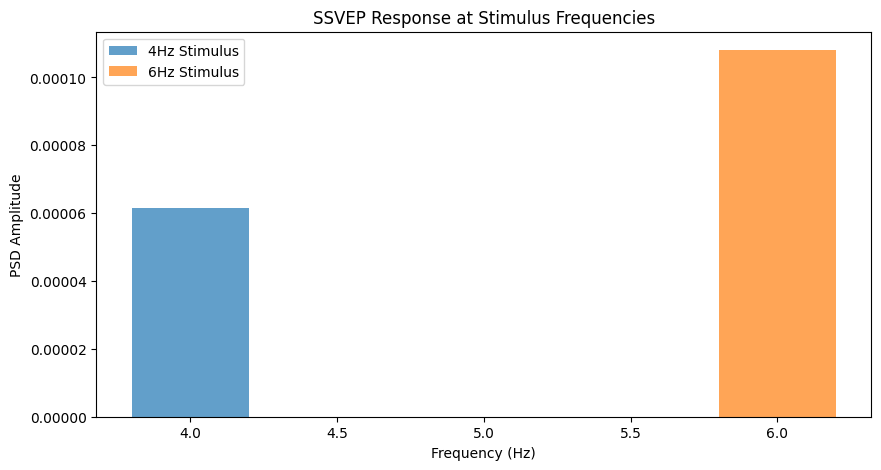

In [5]:
import matplotlib.pyplot as plt

def plot_ssvep_results(psd_results, freqs):
    """
    Plot the average PSD results for different SSVEP frequencies.

    Parameters:
        psd_results (dict): Dictionary with event names as keys and PSD results as values.
        freqs (dict): Dictionary where keys are event names and values are the corresponding frequencies.

    Returns:
        None
    """
    plt.figure(figsize=(10, 5))
    for event, freq_list in freqs.items():
        avg_psd = psd_results[event].mean(axis=1).mean(axis=0)
        plt.bar(freq_list, avg_psd, width=0.4, alpha=0.7, label=f'{event} Stimulus')
    
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD Amplitude')
    plt.title('SSVEP Response at Stimulus Frequencies')
    plt.legend()
    plt.show()

# Plot the results
plot_ssvep_results(psd_results, ssvep_freqs)

### 3. Preprocessing and Compute Forward/Inverse Models for EEG Source Localization

This section involves preprocessing EEG data, computing forward and inverse models, and estimating brain sources during SSVEP tasks. These steps ensure proper data preparation and signal localization for subsequent analysis. Functions are defined for modularity and readability.


1. Importing necessary libraries.
2. Preprocessing EEG data by:
   - Excluding non-EEG channels.
   - Renaming and verifying channels.
   - Setting the montage.
   - Handling missing channel locations.
3. Computing forward and inverse models:
   - Generating a BEM model and solution.
   - Setting up the source space.
   - Computing the forward and inverse solutions.
4. Applying the inverse solution to SSVEP epochs and visualizing source activations.
5. Saving the results for reproducibility.

Functions are defined for modularity and readability.

#### 3.1 Preprocessing EEG Data

Preprocessing involves cleaning and preparing the EEG data for source localization. Key steps include:
- **Excluding non-EEG channels** (e.g., GSR, EXG).
- **Renaming channels** to follow standardized naming conventions.
- **Setting the montage** to the 10-20 EEG system for spatial consistency.
- **Handling missing locations** by dropping channels with undefined electrode positions.
- **Recomputing average reference** to reduce baseline noise and improve signal clarity.

In [6]:
import os
import mne
import numpy as np
from mne.channels import make_standard_montage

def preprocess_eeg(raw, epochs):
    """
    Preprocess EEG data: set channel types, montage, and references.

    Parameters:
        raw (Raw): The raw EEG data.
        epochs (Epochs): The epochs of EEG data to process.
    
    Returns:
        raw (Raw): The processed raw EEG data.
        epochs (Epochs): The processed epochs.
    """
    # Exclude non-EEG channels
    non_eeg_channels = ['EXG1', 'EXG2', 'GSR1', 'GSR2']
    valid_mapping = {ch: 'misc' for ch in non_eeg_channels if ch in raw.info['ch_names']}
    if valid_mapping:
        raw.set_channel_types(valid_mapping)
        print("Non-EEG channels successfully set to 'misc'.")
    raw.pick('eeg')
    print("Non-EEG channels excluded successfully.")

    # Rename channels
    rename_channels(raw)

    # Set montage and handle missing channels
    set_montage_and_check_locs(raw)

    # Recompute average reference
    raw.set_eeg_reference('average', projection=True)
    raw.apply_proj()
    print("EEG average reference set and applied for raw.")
    epochs.set_eeg_reference('average', projection=True)
    epochs.apply_proj()
    print("EEG average reference set and applied for epochs.")
    return raw, epochs

def rename_channels(raw):
    """
    Rename EEG channels to avoid conflicts.

    Parameters:
        raw (Raw): The raw EEG data.
    
    Returns:
        None
    """
    mapping = {'AFp1': 'Fp1', 'AFp2': 'Fp2'}
    conflicting_channels = [
        new_name for new_name in mapping.values() if new_name in raw.info['ch_names']
    ]
    if conflicting_channels:
        print(f"Conflicting target channel names detected: {conflicting_channels}")
        mapping = {k: v for k, v in mapping.items() if v not in conflicting_channels}
    raw.rename_channels(mapping)
    print("Channels renamed successfully.")

def set_montage_and_check_locs(raw):
    """
    Set montage and handle missing EEG channel locations.

    Parameters:
        raw (Raw): The raw EEG data.

    Returns:
        None
    """
    montage = make_standard_montage('standard_1020')
    raw.set_montage(montage, on_missing='ignore')
    print("Standard 10-20 EEG montage set successfully.")

    missing_locs = [
        ch_name for ch_name, ch in zip(raw.info['ch_names'], raw.info['chs'])
        if ch['kind'] == mne.io.constants.FIFF.FIFFV_EEG_CH and not np.any(ch['loc'][:3])
    ]
    if missing_locs:
        print(f"Warning: Missing locations for channels: {missing_locs}")
        raw.drop_channels(missing_locs)
        print(f"Dropped channels with missing locations: {missing_locs}")

raw, epochs = preprocess_eeg(raw, epochs)
epochs.save("results/epochs/OT-epo.fif", overwrite=True)

Non-EEG channels successfully set to 'misc'.
Non-EEG channels excluded successfully.
Conflicting target channel names detected: ['Fp1', 'Fp2']
Channels renamed successfully.
Standard 10-20 EEG montage set successfully.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
EEG average reference set and applied for raw.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
EEG average reference set and applied for epochs.
Overwriting existing fil

/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_6844/3157260551.py:22: RuntimeWarning: The unit for channel(s) EXG1, EXG2, GSR1, GSR2 has changed from V to NA.
  raw.set_channel_types(valid_mapping)


#### 3.2 Compute Forward Models

The forward solution is computed to **map electrical potentials from the brain to EEG electrodes**. This process involves:

- Creating a **Boundary Element Model (BEM)** for head geometry.
- Setting up the **source space** for potential brain activity.
- Verifying the **transformation matrix** for alignment between electrodes and the head model.

In [7]:
import os
import mne
import numpy as np
from mne.channels import make_standard_montage

def compute_bem_and_forward(subject, subjects_dir, raw):
    """
    Compute BEM model, source space, and forward solution.

    Parameters:
        subject (str): Subject ID.
        subjects_dir (str): Path to the FreeSurfer subjects directory.
        raw (Raw): The raw EEG data.

    Returns:
        fwd (Forward): The computed forward solution.
    """
    # Ensure output directory exists
    os.makedirs("results/forward_models", exist_ok=True)
    
    # Step 10: Remove Invalid Channels
    invalid_channels = [
        ch['ch_name']
        for ch in raw.info['chs']
        if ch['kind'] == mne.io.constants.FIFF.FIFFV_EEG_CH and np.isnan(ch['loc'][:3]).any()
    ]
    if invalid_channels:
        print(f"Invalid channels detected: {invalid_channels}")
        raw.drop_channels(invalid_channels)
        print(f"Dropped invalid channels: {invalid_channels}")

    # Set montage and drop channels with missing locations
    montage = make_standard_montage('standard_1020')
    raw.set_montage(montage, on_missing='ignore')
    print("Montage set successfully.")
    
    missing_locs = [
        ch_name for ch_name, ch in zip(raw.info['ch_names'], raw.info['chs'])
        if ch['kind'] == mne.io.constants.FIFF.FIFFV_EEG_CH and not np.any(ch['loc'][:3])
    ]
    if missing_locs:
        print(f"Channels with missing locations: {missing_locs}")
        raw.drop_channels(missing_locs)
        print(f"Dropped {len(missing_locs)} channels with missing locations.")
    
    # BEM model and solution
    subjects_dir = os.path.expanduser(subjects_dir)
    bem_model_file = os.path.join(subjects_dir, subject, "bem", f"{subject}-bem-model.fif")
    bem_solution_file = os.path.join(subjects_dir, subject, "bem", f"{subject}-bem-sol.fif")
    src_file = os.path.join(subjects_dir, subject, "bem", f"{subject}-oct-6-src.fif")
    
    # Forward solution
    trans = f"{subjects_dir}/{subject}/bem/{subject}-trans.fif"
    if not os.path.exists(trans):
        raise FileNotFoundError(f"Transformation file {trans} not found. Ensure coregistration is complete.")
    fwd = mne.make_forward_solution(raw.info, trans=trans, src=src_file, bem=bem_solution_file, eeg=True)
    
    # Save forward solution
    fwd_path = "results/forward_models/OT-fwd.fif"
    mne.write_forward_solution(fwd_path, fwd, overwrite=True)
    print(f"Forward solution saved successfully at {fwd_path}")
    
    return fwd


# Call the function and save the forward model
fwd = compute_bem_and_forward("OT", "~/freesurfer/7.4.1/subjects", raw)

Invalid channels detected: ['AFp1', 'AFF5h', 'AFF1h', 'FFT9h', 'FFT7h', 'FFC5h', 'FFC3h', 'FFC1h', 'FTT9h', 'FTT7h', 'FCC5h', 'FCC3h', 'FCC1h', 'TTP7h', 'CCP5h', 'CCP3h', 'CCP1h', 'TPP7h', 'CPP5h', 'CPP3h', 'CPP1h', 'PPO9h', 'PPO5h', 'PPO1h', 'POO9h', 'POO1', 'I1', 'OI1h', 'AFp2', 'AFF2h', 'AFF6h', 'FFC2h', 'FFC4h', 'FFC6h', 'FFT8h', 'FFT10h', 'FCC2h', 'FCC4h', 'FCC6h', 'FTT8h', 'FTT10h', 'CCP2h', 'CCP4h', 'CCP6h', 'TTP8h', 'CPP2h', 'CPP4h', 'CPP6h', 'TPP8h', 'PPO2h', 'PPO6h', 'PPO10h', 'POO2', 'POO10h', 'OI2h', 'I2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Erg1', 'Erg2', 'Resp', 'Plet', 'Temp']
Dropped invalid channels: ['AFp1', 'AFF5h', 'AFF1h', 'FFT9h', 'FFT7h', 'FFC5h', 'FFC3h', 'FFC1h', 'FTT9h', 'FTT7h', 'FCC5h', 'FCC3h', 'FCC1h', 'TTP7h', 'CCP5h', 'CCP3h', 'CCP1h', 'TPP7h', 'CPP5h', 'CPP3h', 'CPP1h', 'PPO9h', 'PPO5h', 'PPO1h', 'POO9h', 'POO1', 'I1', 'OI1h', 'AFp2', 'AFF2h', 'AFF6h', 'FFC2h', 'FFC4h', 'FFC6h', 'FFT8h', 'FFT10h', 'FCC2h', 'FCC4h', 'FCC6h', 'FTT8h', 'FTT10h

#### 3.3. Computing Inverse Operator

The inverse operator **maps EEG signals back to brain sources**, enabling the **localization** of neural activity.

In [8]:
def compute_inverse_operator(raw, fwd, epochs):
    """
    Compute inverse operator using forward solution and noise covariance.

    Parameters:
        raw (Raw): The raw EEG data.
        fwd (Forward): The forward solution.
        epochs (Epochs): The epochs of EEG data to process.

    Returns:
        inverse_operator (InverseOperator): The computed inverse operator.
    """
    noise_cov = mne.compute_covariance(epochs, tmax=0., method='auto')
    inverse_operator = mne.minimum_norm.make_inverse_operator(
        raw.info, fwd, noise_cov, loose=0.2, depth=0.8
    )
    print("Inverse operator created successfully.")
    return inverse_operator

inverse_operator = compute_inverse_operator(raw, fwd, epochs)

    Created an SSP operator (subspace dimension = 1)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 143 -> 138
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EEG regularization : 0.1
    EEG regularization : 0.1
    EEG regularization : 0.1
Number of samples used : 9064
log-likelihood on unseen data (descending order):
   empirical: -234.345
   shrunk: -234.385
   diagonal_fixed: -320.474
selecting best estimator: empirical
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 72 channels.
    72 out of 72 channels remain after picking
Selected 72 chann

#### 3.4. Applying Inverse Solutions

We estimate brain activity during the 4 Hz and 6 Hz stimuli and save the source estimates for later visualization.

In [9]:
def apply_inverse_solution(epochs, inverse_operator, subject, subjects_dir):
    """
    Apply inverse solution to epochs and save the results.

    Parameters:
        epochs (Epochs): The epochs to apply the inverse solution to.
        inverse_operator (InverseOperator): The inverse operator.
        subject (str): Subject ID.
        subjects_dir (str): Path to the FreeSurfer subjects directory.

    Returns:
        stc_4hz (SourceEstimate): Source estimate for the 4Hz condition.
        stc_6hz (SourceEstimate): Source estimate for the 6Hz condition.
    """
    # Ensure results directories exist
    os.makedirs("results/source_estimates", exist_ok=True)
    os.makedirs("results/activation_movies", exist_ok=True)
    os.makedirs("results/epochs", exist_ok=True)
    
    stc_4hz = mne.minimum_norm.apply_inverse(
        epochs['4Hz'].average(), inverse_operator, lambda2=1. / 9., method='dSPM'
    )
    stc_6hz = mne.minimum_norm.apply_inverse(
        epochs['6Hz'].average(), inverse_operator, lambda2=1. / 9., method='dSPM'
    )
    # Save source estimates
    stc_4hz.save('results/source_estimates/ssvep_4hz_source', overwrite=True)
    stc_6hz.save('results/source_estimates/ssvep_6hz_source', overwrite=True)
    print("Source estimates saved successfully.")
    return stc_4hz, stc_6hz

stc_4hz, stc_6hz = apply_inverse_solution(epochs, inverse_operator, "OT", "~/freesurfer/7.4.1/subjects")

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 40
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 71 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "4Hz"...
    Picked 72 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  44.1% variance
    Combining the current components...
    dSPM...
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 40
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 71 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "6H

#### 3.5 Set Up the Environment

Ensures the correct setup of the `SUBJECTS_DIR` environment variable for FreeSurfer, which is essential for accessing subject data and parcellations.

In [10]:
import os

def set_subjects_dir():
    """
    Ensure SUBJECTS_DIR is set.

    Returns:
        subjects_dir (str): Path to the FreeSurfer subjects directory.
    """
    subjects_dir = os.path.expanduser("~/freesurfer/7.4.1/subjects")
    os.environ["SUBJECTS_DIR"] = subjects_dir
    return subjects_dir

# Set subjects directory
subjects_dir = set_subjects_dir()

### 4. EEG Source Localization and Movie Generation

This section details the process of localizing EEG sources to specific brain regions and generating activation movies for two frequency bands (4 Hz and 6 Hz). These steps involve selecting a region of interest (ROI) from parcellation labels, visualizing source activations, and saving the results as MP4 movies (brain activations for the specified ROI over time).

#### Usage:
- Set your subject ID, parcellation name, and the region of interest (ROI) label.
- The script will list all available labels and ensure the appropriate label is used.
- Movies for 4Hz and 6Hz activation will be generated and saved as `4Hz_activation.mp4` 
  and `6Hz_activation.mp4`.

#### Dependencies:
- **MNE-Python**
- **FreeSurfer** (for the subject data and parcellation)
- **imageio** (for saving the movie)

#### 4.1 List Available Labels

Lists all available labels in the parcellation to allow the user to choose the appropriate ROI.

In [11]:
from mne import read_labels_from_annot

def list_available_labels(subject, parc, subjects_dir):
    """
    List all available labels in the annotation.

    Parameters:
        subject (str): Subject ID.
        parc (str): Parcellation type (e.g., 'aparc').
        subjects_dir (str): Path to the FreeSurfer subjects directory.

    Returns:
        labels (list): List of available labels in the parcellation.
    """
    labels = read_labels_from_annot(subject, parc=parc, subjects_dir=subjects_dir)
    print("Available labels:")
    for label in labels:
        print(label.name)
    return labels

subject = "OT"  # Replace with your subject ID
parc = "aparc"  # Parcellation type

# List available labels
labels = list_available_labels(subject, parc, subjects_dir)

Reading labels from parcellation...
   read 34 labels from /Users/michaelzhou/freesurfer/7.4.1/subjects/OT/label/lh.aparc.annot
   read 34 labels from /Users/michaelzhou/freesurfer/7.4.1/subjects/OT/label/rh.aparc.annot
Available labels:
bankssts-lh
bankssts-rh
caudalanteriorcingulate-lh
caudalanteriorcingulate-rh
caudalmiddlefrontal-lh
caudalmiddlefrontal-rh
cuneus-lh
cuneus-rh
entorhinal-lh
entorhinal-rh
frontalpole-lh
frontalpole-rh
fusiform-lh
fusiform-rh
inferiorparietal-lh
inferiorparietal-rh
inferiortemporal-lh
inferiortemporal-rh
insula-lh
insula-rh
isthmuscingulate-lh
isthmuscingulate-rh
lateraloccipital-lh
lateraloccipital-rh
lateralorbitofrontal-lh
lateralorbitofrontal-rh
lingual-lh
lingual-rh
medialorbitofrontal-lh
medialorbitofrontal-rh
middletemporal-lh
middletemporal-rh
paracentral-lh
paracentral-rh
parahippocampal-lh
parahippocampal-rh
parsopercularis-lh
parsopercularis-rh
parsorbitalis-lh
parsorbitalis-rh
parstriangularis-lh
parstriangularis-rh
pericalcarine-lh
perical

#### 4.2 Select the Region of Interest (ROI)

Selects the desired label corresponding to the ROI from the list of available labels. The label is used to restrict the source estimate computation to a specific brain region.

In [12]:
def get_roi_label(labels, label_name):
    """
    Retrieve the ROI label from the list of labels.

    Parameters:
        labels (list): List of available labels.
        label_name (str): Name of the label corresponding to the ROI.

    Returns:
        roi_label (Label): The label object for the specified ROI.
    """
    roi_label = [label for label in labels if label.name == label_name]
    if not roi_label:
        raise ValueError(f"Label '{label_name}' not found in the annotation.")
    return roi_label[0]  # Use the first match if found

# Define the label name for ROI
label_name = "lingual-lh"  # Replace with your region of interest
roi_label = get_roi_label(labels, label_name)

#### 4.3 Generate Activation Movies

Visualizes source activations for 4 Hz and 6 Hz stimuli in the specified ROI and saves the results as movies in MP4 format.

In [13]:
def plot_and_save_activation_movie(stc, roi_label, subject, subjects_dir, filename, time_dilation=10, framerate=24):
    """
    Plot the source estimate and save the activation as a movie.
    
    Parameters:
        stc: SourceEstimate object.
        roi_label: Label object representing the region of interest.
        subject: str, subject ID.
        subjects_dir: str, path to the SUBJECTS_DIR.
        filename: str, output movie filename.
        time_dilation: float, time dilation factor for the movie.
        framerate: int, frames per second for the movie.
    """
    # Plot and restrict source estimate to ROI
    stc.plot(subject=subject, subjects_dir=subjects_dir, time_viewer=False)
    roi_activations = stc.in_label(roi_label)  # Use the label object
    
    # Save the visualization as a movie
    brain = stc.plot(subject=subject, subjects_dir=subjects_dir, time_viewer=False)
    brain.save_movie(f"results/activation_movies/{filename}", time_dilation=time_dilation, framerate=framerate)
    print(f"Saved movie: {filename}")

# Plot and save 4Hz activation
plot_and_save_activation_movie(
    stc_4hz, roi_label, subject, subjects_dir, filename="4Hz_activation.mp4"
)

# Plot and save 6Hz activation
plot_and_save_activation_movie(
    stc_6hz, roi_label, subject, subjects_dir, filename="6Hz_activation.mp4"
)

Using pyvistaqt 3d backend.
Using control points [3.9921354  4.49723901 8.78319396]
Using control points [3.9921354  4.49723901 8.78319396]


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1600, 1550) to (1600, 1552) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saved movie: 4Hz_activation.mp4
Using control points [4.31144847 4.81377283 7.74134993]
Using control points [4.31144847 4.81377283 7.74134993]


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1600, 1550) to (1600, 1552) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saved movie: 6Hz_activation.mp4


### 5. Ground Truth Center Of Mass (COM) Calculation from MRI Data.

In this section, we will calculate the **Center of Mass (COM)** for the lesion regions of interest (ROIs) from structural MRI data. The COM will serve as the ground truth for comparison against the EEG-derived COM results.

#### 5.1 Loading MRI Data and Masking

Here, we will load the MRI data (e.g., `OT_defaced.nii.gz`), segment it to extract the lesion region (if applicable), and calculate the COM.

In [14]:
# 5.1 Load MRI Data for the Subject (OT)
import nibabel as nib
from scipy.ndimage import center_of_mass
import matplotlib.pyplot as plt
import numpy as np

# Load the MRI scan (defaced)
mri_path = "datasets/MRI_dataset/OT_defaced.nii.gz"  # Adjust path
mri_img = nib.load(mri_path)

# Get the MRI data in array form
mri_data = mri_img.get_fdata()

#### 5.2 Lesion Masking and Ground Truth COM Calculation

This section covers the interactive thresholding for lesion segmentation, calculation of the lesion mask, and the computation of the **Center of Mass (COM)** for the lesion mask, which will be used for further analysis.

##### 5.2.1 Displaying MRI Slice and Basic Statistics

In this sub-section, we load and display a slice from the MRI data, and compute basic statistics (e.g., min, max, mean, and standard deviation) to understand the intensity distribution in the data.

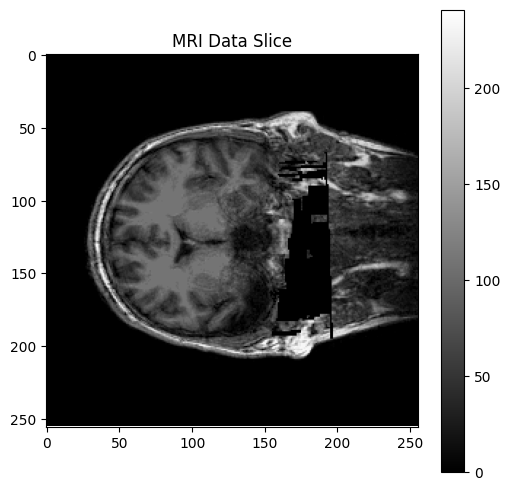

Min intensity: 0.0
Max intensity: 255.0
Mean intensity: 17.947287559509277
Median intensity: 0.0
Standard deviation: 37.022172374409195


In [15]:
# Load MRI data (assuming mri_data is already loaded)
slice_index = mri_data.shape[2] // 2  # Middle slice for visualization

# Display MRI data slice
plt.figure(figsize=(6, 6))
plt.imshow(mri_data[:, :, slice_index], cmap="gray")
plt.colorbar()
plt.title("MRI Data Slice")
plt.show()

# Print basic statistics
print(f"Min intensity: {mri_data.min()}")
print(f"Max intensity: {mri_data.max()}")
print(f"Mean intensity: {mri_data.mean()}")
print(f"Median intensity: {np.median(mri_data)}")
print(f"Standard deviation: {mri_data.std()}")

##### 5.2.2 Threshold Selection for Lesion Masking

This sub-section allows for interactive threshold selection to generate a binary mask of the lesions in the MRI data. The lesion mask is displayed on top of the MRI slice to visualize the segmented areas.

In [16]:
# Create a function to update threshold and slice index for interactive visualization
def update_threshold(threshold_value, slice_index):
    # Create a binary mask for lesions
    lesion_mask = mri_data > threshold_value

    # Visualize the lesion mask overlay on MRI data
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(mri_data[:, :, slice_index], cmap="gray", alpha=0.7)
    ax.imshow(lesion_mask[:, :, slice_index], cmap="Reds", alpha=0.3)
    ax.set_title(f"Lesion Mask Overlay (Threshold: {threshold_value:.2f})")
    
    # Compute COM for the lesion mask
    ground_truth_com = center_of_mass(lesion_mask)
    print(f"Ground Truth COM (x, y, z): {ground_truth_com}")
    
    # Visualize COM on the MRI slice
    com_x, com_y, com_z = ground_truth_com
    ax.plot(com_y, com_x, marker="o", color="blue", markersize=8)
    plt.show()

    # Save the MRI slice and lesion mask with COM marked
    fig.savefig(f"results/mri_slice_com/mri_slice_com_{threshold_value:.2f}.png")
    print(f"Saved MRI slice with COM overlay at results/mri_slice_com/mri_slice_com_{threshold_value:.2f}.png")

In [17]:
# Set and validate a threshold
k = 1.5  # Adjustable threshold scaling factor
threshold_value_mean_std = mri_data.mean() + k * mri_data.std()
threshold_value_max = 0.5 * max(mri_data.flatten())

# Add options for the threshold
print(f"Threshold options:")
print(f"1. Mean + 1.5 * Std: {threshold_value_mean_std}")
print(f"2. 0.5 * Max intensity: {threshold_value_max}")

# Choose a threshold based on visual inspection or adjust manually
threshold_value = threshold_value_mean_std  # Set the default threshold (Option 1)

print(f"Using threshold value: {threshold_value}, using option 1")

Threshold options:
1. Mean + 1.5 * Std: 73.48054612112307
2. 0.5 * Max intensity: 127.5
Using threshold value: 73.48054612112307, using option 1


##### 5.3 Computing Center of Mass (COM) for Lesion Mask

This section computes the **Center of Mass (COM)** for the lesion mask at the selected threshold. The COM is then visualized on the MRI slice, marking the lesion's center.

Ground Truth COM (x, y, z): (np.float64(125.87572347661884), np.float64(120.58387122437925), np.float64(105.36671007233889))


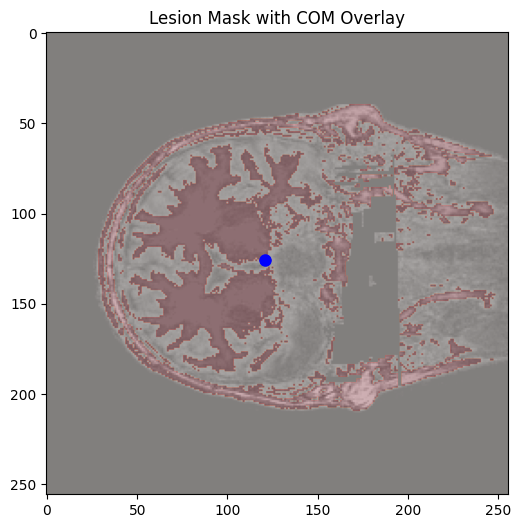

In [18]:
# Compute COM for the lesion mask
lesion_mask = mri_data > threshold_value
ground_truth_com = center_of_mass(lesion_mask)
com_x, com_y, com_z = ground_truth_com
print(f"Ground Truth COM (x, y, z): {ground_truth_com}")

# Visualize COM on the MRI slice
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(mri_data[:, :, slice_index], cmap="gray", alpha=0.7)
ax.imshow(lesion_mask[:, :, slice_index], cmap="Reds", alpha=0.3)
ax.plot(com_y, com_x, marker="o", color="blue", markersize=8)  # Plot COM as a blue dot
ax.set_title(f"Lesion Mask with COM Overlay")
plt.show()

##### 5.2.4 Saving Results (Lesion Mask and COM Data)

Once the lesion mask is created and the COM is calculated, the results are saved for further analysis. This includes the lesion mask and COM data in both image and text formats.

In [19]:
# Save the lesion mask for further analysis
np.save(f"results/lesion_mask/lesion_mask_{threshold_value:.2f}.npy", lesion_mask)
print(f"Lesion mask saved successfully at results/lesion_mask/lesion_mask_{threshold_value:.2f}.npy")

# Save COM results in a text file
com_results_path = "results/com_results.txt"
with open(com_results_path, "a") as f:  # Append COM results
    f.write(f"Ground Truth COM (x, y, z) at Threshold {threshold_value:.2f}: {ground_truth_com}\n")
print(f"Center of Mass results saved successfully at {com_results_path}")

Lesion mask saved successfully at results/lesion_mask/lesion_mask_73.48.npy
Center of Mass results saved successfully at results/com_results.txt


##### 5.2.5 Interactive Threshold Slider and COM Calculation

This sub-section provides an interactive slider for adjusting the threshold and recalculating the lesion mask and COM in real time.

In [20]:
import ipywidgets as widgets
from IPython.display import display

# Create sliders for threshold adjustment and slice selection
threshold_slider = widgets.FloatSlider(
    value=mri_data.mean() + 1.5 * mri_data.std(),  # Default value based on mean + 1.5 * std
    min=mri_data.min(),
    max=mri_data.max(),
    step=(mri_data.max() - mri_data.min()) / 100.0,
    description='Threshold:',
    continuous_update=False
)

slice_slider = widgets.IntSlider(
    value=mri_data.shape[2] // 2,  # Default slice index is the middle slice
    min=0,
    max=mri_data.shape[2] - 1,
    step=1,
    description="Slice Index",
    continuous_update=False
)

# Create a save button
save_button = widgets.Button(description="Save Image")

# Function to update the threshold and slice preview
def update_threshold(threshold_value, slice_index):
    # Create a binary mask for lesions
    lesion_mask = mri_data > threshold_value

    # Visualize the lesion mask overlay on MRI data
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(mri_data[:, :, slice_index], cmap="gray", alpha=0.7)
    ax.imshow(lesion_mask[:, :, slice_index], cmap="Reds", alpha=0.3)
    ax.set_title(f"Lesion Mask Overlay (Threshold: {threshold_value:.2f})")
    plt.show()

# Function to save the current figure
def save_image(b):
    slice_index = slice_slider.value
    threshold_value = threshold_slider.value
    # Create a binary mask for lesions
    lesion_mask = mri_data > threshold_value

    # Save the image
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(mri_data[:, :, slice_index], cmap="gray", alpha=0.7)
    ax.imshow(lesion_mask[:, :, slice_index], cmap="Reds", alpha=0.3)
    ax.set_title(f"Lesion Mask Overlay (Threshold: {threshold_value:.2f})")
    
    # Save the visualization as a PNG file
    plt.savefig(f"results/lesion_mask/lesion_mask_{threshold_value:.2f}_slice_{slice_index}.png")
    print(f"Lesion mask saved as results/lesion_mask/lesion_mask_{threshold_value:.2f}_slice_{slice_index}.png")

# Link the save button to the save_image function
save_button.on_click(save_image)

# Display interactive widgets
widgets.interact(update_threshold, threshold_value=threshold_slider, slice_index=slice_slider)
display(save_button)

interactive(children=(FloatSlider(value=73.48054612112307, continuous_update=False, description='Threshold:', …

Button(description='Save Image', style=ButtonStyle())

##### 5.2.6 Export COM results as CSV

Save COM results to CSV for further analysis.

In [21]:
# Export COM results as a CSV for further analysis
def export_com_data_to_csv():
    import pandas as pd
    com_results_path = "results/com_results.txt"
    csv_output_path = "results/com_results.csv"
    
    # Read text file and convert to CSV
    with open(com_results_path, "r") as f:
        lines = f.readlines()

    data = []
    for line in lines:
        parts = line.strip().split(":")
        if len(parts) == 2:
            threshold_info, com_info = parts
            threshold = threshold_info.split(" ")[-1]
            com_values = com_info.strip("()").split(", ")
            data.append([threshold] + com_values)
    
    # Create a DataFrame and save as CSV
    df = pd.DataFrame(data, columns=["Threshold", "COM_X", "COM_Y", "COM_Z"])
    df.to_csv(csv_output_path, index=False)
    print(f"COM results exported successfully to {csv_output_path}")

# Call the function to export COM data
export_com_data_to_csv()

COM results exported successfully to results/com_results.csv


#### 5.3 EEG Source Localization COM Calculation

This section calculates the **Center of Mass (COM)** for the **EEG source estimates (4Hz and 6Hz)** in the **left and right hemispheres**. This represents the **EEG-based spatial localization**.

In [22]:
# Compute center of mass (COM) for the source estimates of 4Hz and 6Hz
com_4hz_left = stc_4hz.center_of_mass(hemi=0)  # Left hemisphere
com_4hz_right = stc_4hz.center_of_mass(hemi=1)  # Right hemisphere

com_6hz_left = stc_6hz.center_of_mass(hemi=0)  # Left hemisphere
com_6hz_right = stc_6hz.center_of_mass(hemi=1)  # Right hemisphere

print(f"Center of Mass for 4Hz (Left): {com_4hz_left}")
print(f"Center of Mass for 4Hz (Right): {com_4hz_right}")
print(f"Center of Mass for 6Hz (Left): {com_6hz_left}")
print(f"Center of Mass for 6Hz (Right): {com_6hz_right}")

# Save the COM results in a text file
com_results_path = "results/com_results.txt"
with open(com_results_path, "a") as f:  # Use "a" to append to the file
    f.write(f"Center of Mass for 4Hz (Left): {com_4hz_left}\n")
    f.write(f"Center of Mass for 4Hz (Right): {com_4hz_right}\n")
    f.write(f"Center of Mass for 6Hz (Left): {com_6hz_left}\n")
    f.write(f"Center of Mass for 6Hz (Right): {com_6hz_right}\n")

print(f"Center of Mass results saved successfully at {com_results_path}")

Center of Mass for 4Hz (Left): (np.int64(13180), 0, np.float64(0.742504767490186))
Center of Mass for 4Hz (Right): (np.int64(15111), 1, np.float64(0.742504767490186))
Center of Mass for 6Hz (Left): (np.int64(20617), 0, np.float64(0.7223668427268242))
Center of Mass for 6Hz (Right): (np.int64(13330), 1, np.float64(0.7223668427268242))
Center of Mass results saved successfully at results/com_results.txt


#### 5.4 Convex Spectral Clustering (CSpeC) for Neural Activations

In this section, we implement **Convex Spectral Clustering (CSpeC)** to group spatially contiguous regions of interest based on neural activation maps. This step builds on the lesion masks derived earlier and clusters the regions for further analysis.

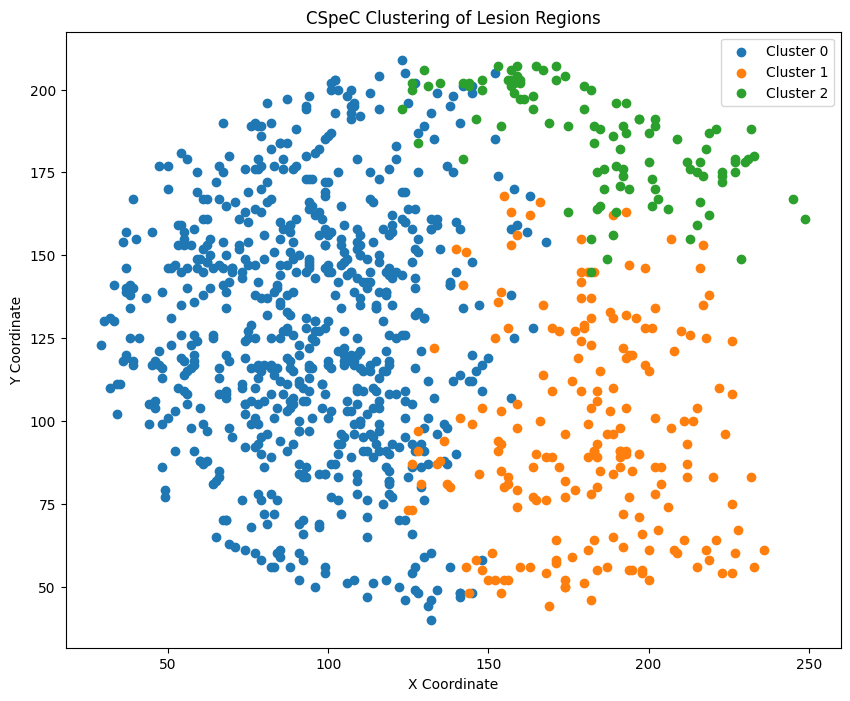

In [23]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import euclidean_distances
from scipy.sparse import csr_matrix
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
random_seed = 1
np.random.seed(random_seed)

# Step 1: Extract data points from lesion mask
data_points = np.argwhere(lesion_mask)  # Get coordinates of active regions

# Downsample data points to avoid memory issues
num_samples = 1000  # Adjust based on memory
if len(data_points) > num_samples:
    sampled_indices = np.random.choice(len(data_points), num_samples, replace=False)
    data_points = data_points[sampled_indices]

# Step 2: Compute sparse similarity matrix
sigma = 2.0  # Adjust based on data
distances = euclidean_distances(data_points, data_points)
similarity_matrix = np.exp(-distances / (2 * sigma**2))
similarity_matrix[similarity_matrix < 1e-3] = 0  # Threshold small values
similarity_matrix = csr_matrix(similarity_matrix)  # Convert to sparse matrix

# Step 3: Perform spectral clustering
n_clusters = 3  # Number of clusters
spectral_clustering = SpectralClustering(
    n_clusters=n_clusters,
    affinity='precomputed',
    assign_labels='kmeans',
    random_state=random_seed  # Set random state for clustering
)
cluster_labels = spectral_clustering.fit_predict(similarity_matrix.toarray())

# Save clusters as a .npy file
np.save("results/cluster_labels.npy", cluster_labels)

# Step 4: Visualize clusters
plt.figure(figsize=(10, 8))
for cluster_idx in range(n_clusters):
    cluster_points = data_points[cluster_labels == cluster_idx]
    plt.scatter(cluster_points[:, 1], cluster_points[:, 0], label=f"Cluster {cluster_idx}")
plt.title("CSpeC Clustering of Lesion Regions")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.savefig("results/cspec_clusters.png")
plt.show()

##### 5.4.1 Cluster Analysis and Overlay Visualization

This subsection analyzes the clustering results obtained using the CSpeC framework. 

**Silhouette Score**

The **Silhouette Score** is used to measure the quality of clustering by quantifying how well each data point matches within its assigned cluster compared to other clusters. A higher score indicates better-defined clusters.

In [24]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(data_points, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.26915701202691966


While the clusters are distinguishable, the moderate score suggests there might be some overlap or less distinct separations between clusters.

**Overlay Visualization**

The clustering results are visualized by overlaying the cluster assignments on the MRI slices. Each cluster is represented by a unique color, allowing an intuitive comparison of their spatial distribution with the underlying anatomical structures.

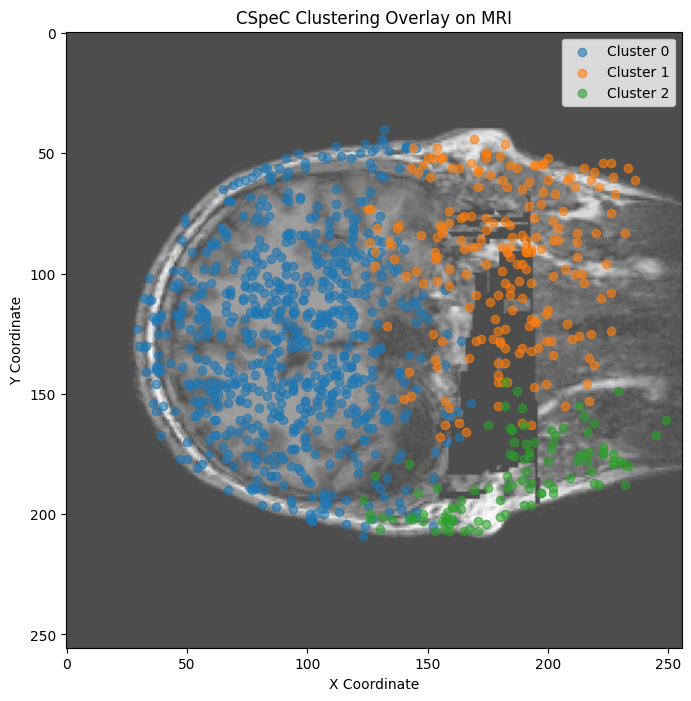

In [25]:
plt.figure(figsize=(10, 8))
plt.imshow(mri_data[:, :, slice_index], cmap="gray", alpha=0.7)
for cluster_idx in range(n_clusters):
    cluster_points = data_points[cluster_labels == cluster_idx]
    plt.scatter(cluster_points[:, 1], cluster_points[:, 0], label=f"Cluster {cluster_idx}", alpha=0.6)
plt.title("CSpeC Clustering Overlay on MRI")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.show()

**Visualization**: The plot shows how each cluster is distributed relative to the MRI anatomy.

**Cluster Centroids and Distance to Ground Truth Center of Mass (COM)**

To evaluate the spatial alignment of clusters, we compute the centroids of each cluster and their Euclidean distance from the ground truth COM.

In [26]:
from scipy.spatial.distance import cdist

cluster_centroids = np.array([data_points[cluster_labels == i].mean(axis=0) for i in range(n_clusters)])
com_coordinates = np.array(ground_truth_com)
distances_to_com = cdist(cluster_centroids, [com_coordinates])
print(f"Distances from cluster centroids to COM: {distances_to_com}")

Distances from cluster centroids to COM: [[26.57346027]
 [72.54536748]
 [88.90232634]]


As we can see, cluster centroids vary in proximity to the ground truth COM, reflecting their spatial relevance to the lesion region.

**Mean Intensities per Cluster**

To assess the MRI intensity values within each cluster, we calculate the mean intensity for all data points in each cluster. This metric provides insights into how the clustering corresponds to variations in intensity values, which may correlate with tissue characteristics.

In [27]:
mean_intensities = [
    float(mri_data[data_points[cluster_labels == i, 0], data_points[cluster_labels == i, 1], slice_index].mean())
    for i in range(n_clusters)
]
print(f"Mean intensities per cluster: {mean_intensities}")

Mean intensities per cluster: [81.05172413793103, 54.23762376237624, 80.48039215686275]


The intensity values above reflect distinct regions within the MRI slice, further supporting the clustering validity.

##### Summary of Clustering Analysis

The clustering analysis highlights the ability of the CSpeC framework to group lesion regions effectively. The integration of metrics like the Silhouette Score, distance to COM, and mean intensities allows a comprehensive evaluation of clustering performance:
- **Silhouette Score**: Provides an overall measure of clustering quality.
- **Overlay Visualization**: Facilitates visual interpretation of spatial distributions.
- **Distances to COM**: Quantifies alignment with the ground truth.
- **Mean Intensities**: Offers additional validation based on intensity profiles.

This analysis demonstrates the utility of clustering techniques in understanding lesion region distributions within the SilenceMap framework.

### 6. Center of Mass (COM) Distance Calculation

In this section, we calculate the distance between the **ground truth COM** derived from the MRI data and the **EEG-based COM** for the 4Hz and 6Hz frequency bands. These distances help assess the accuracy of the EEG-based COM predictions.

#### 6.1 Compute COM Distances

Calculate the distance between the ground truth COM (from MRI) and the EEG-derived COMs.

In [28]:
import numpy as np

# Compare these coordinates using the Euclidean distance
def compute_com_distance(com1, com2):
    return np.linalg.norm(np.array(com1) - np.array(com2))


# Compare with the 4Hz COM (Left and Right)
distance_4hz_left = compute_com_distance(ground_truth_com, com_4hz_left)
distance_4hz_right = compute_com_distance(ground_truth_com, com_4hz_right)

# Compare with the 6Hz COM (Left and Right)
distance_6hz_left = compute_com_distance(ground_truth_com, com_6hz_left)
distance_6hz_right = compute_com_distance(ground_truth_com, com_6hz_right)

# Output the distances
print(f"Distance between Ground Truth COM and 4Hz (Left) COM: {distance_4hz_left:.2f} mm")
print(f"Distance between Ground Truth COM and 4Hz (Right) COM: {distance_4hz_right:.2f} mm")
print(f"Distance between Ground Truth COM and 6Hz (Left) COM: {distance_6hz_left:.2f} mm")
print(f"Distance between Ground Truth COM and 6Hz (Right) COM: {distance_6hz_right:.2f} mm")

Distance between Ground Truth COM and 4Hz (Left) COM: 13055.10 mm
Distance between Ground Truth COM and 4Hz (Right) COM: 14985.97 mm
Distance between Ground Truth COM and 6Hz (Left) COM: 20491.75 mm
Distance between Ground Truth COM and 6Hz (Right) COM: 13205.08 mm


#### 6.2 Save COM Distance Results

Save the results of the COM distance comparison in a file for later use.

In [29]:
# Save the COM distances in a text file
com_distance_results_path = "results/com_distances.txt"
with open(com_distance_results_path, "w") as f:
    f.write(f"Distance between Ground Truth COM and 4Hz (Left) COM: {distance_4hz_left:.2f} mm\n")
    f.write(f"Distance between Ground Truth COM and 4Hz (Right) COM: {distance_4hz_right:.2f} mm\n")
    f.write(f"Distance between Ground Truth COM and 6Hz (Left) COM: {distance_6hz_left:.2f} mm\n")
    f.write(f"Distance between Ground Truth COM and 6Hz (Right) COM: {distance_6hz_right:.2f} mm\n")

print(f"COM distance results saved successfully at {com_distance_results_path}")

COM distance results saved successfully at results/com_distances.txt


### 7. SilenceMap Algorithm (Tentative Demo - Formal Version in Part1 Notebook)

The **SilenceMap** Algorithm is designed to identify regions of **neural silence** from EEG data, characterized by minimal activation across specific frequency bands. This information is critical for understanding neural suppression, inhibition, or moments of rest in brain activity.

The algorithm works in two stages:
1. **Low-Resolution Initialization**: Create a coarse representation of the activation map.
2. **High-Resolution Refinement**: Refine the coarse map into a high-resolution grid while maintaining focus on regions of interest.

#### 7.1 Low-Resolution Initialization

This step initializes a **coarse grid** over the EEG data channels. Each grid point represents the activation within a given frequency band (e.g., alpha band, 8-12 Hz).

The goal is to quickly identify areas with lower levels of activation, which may correspond to neural silences. Each activation value is computed by:
- Mapping grid points to EEG channels.
- Combining signals from channels.
- Calculating power spectral density (PSD) for the selected frequency band.


In [49]:
def compute_activation_at_point(raw, x, y, freq_band=(8, 12)):
    """
    Compute activation at a specific grid point (x, y).

    Parameters:
        raw (Raw): Preprocessed EEG data.
        x (float): Grid point in the x-dimension.
        y (float): Grid point in the y-dimension.
        freq_band (tuple): Frequency band for activation computation (default: alpha band).

    Returns:
        activation (float): Activation value at the grid point.
    """
    # Convert grid points to nearest channel indices
    channel_x = int(np.clip(x, 0, raw.info['nchan'] - 1))
    channel_y = int(np.clip(y, 0, raw.info['nchan'] - 1))
    
    # Extract EEG data for the selected channels
    eeg_data_x = raw.get_data(picks=channel_x)
    eeg_data_y = raw.get_data(picks=channel_y)
    
    # Combine signals from both channels (e.g., average or sum)
    combined_signal = (eeg_data_x + eeg_data_y) / 2.0
    
    # Compute power spectral density (PSD)
    freqs, psd = welch(combined_signal, fs=raw.info['sfreq'], nperseg=256)
    
    # Ensure boolean indexing matches the PSD shape
    freq_mask = (freqs >= freq_band[0]) & (freqs <= freq_band[1])
    band_power = psd[:, freq_mask].sum(axis=1).mean()  # Average across channels
    
    return band_power

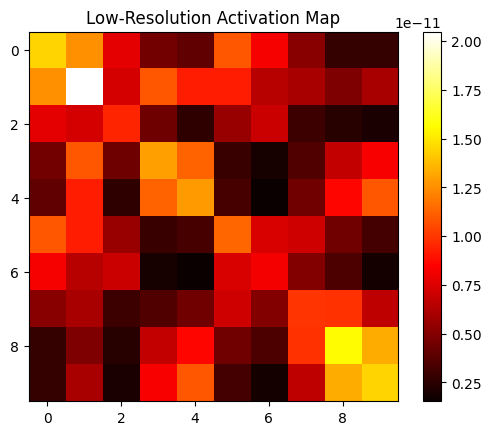

In [50]:
## Step 1: Low-Resolution Initialization
def low_resolution_initialization(raw, resolution=10):
    """
    Perform low-resolution initialization to identify regions of interest.

    Parameters:
        raw (Raw): Preprocessed EEG data.
        resolution (int): Grid resolution (default is 10).

    Returns:
        low_res_map: Initial activation map at low resolution.
    """
    # Generate a low-resolution grid
    low_res_grid = np.linspace(0, raw.info['nchan'], resolution)
    
    # Initialize low-res activation map
    low_res_map = np.zeros((len(low_res_grid), len(low_res_grid)))
    
    # Compute activation for each grid point
    for i, x in enumerate(low_res_grid):
        for j, y in enumerate(low_res_grid):
            activation = compute_activation_at_point(raw, x, y)
            low_res_map[i, j] = activation
    
    return low_res_map

## Visualize Low-Resolution Map
low_res_map = low_resolution_initialization(raw)
plt.imshow(low_res_map, cmap="hot")
plt.title("Low-Resolution Activation Map")
plt.colorbar()
plt.show()

#### 7.2 High-Resolution Refinement

Building on the low-resolution map, this step refines the representation by:
- Increasing grid resolution (determined by the `refinement_factor`).
- Dynamically computing a threshold to identify significant areas of interest (e.g., regions of low activation).
- Interpolating activations at finer grid points.

This stage ensures that regions of neural silence are preserved and highlighted in the final high-resolution map. The process uses weighted activation calculations to enhance spatial precision.

Dynamic Threshold: 9.554913995843413e-12
High-res grid size: 30x30
Low-res value at (0, 0): 1.4474619405974774e-11
Point (0.00, 0.00) passed threshold with low-res value: 1.4474619405974774e-11
Computed activation: 1.4474619405974774e-11
Low-res value at (0, 0): 1.4474619405974774e-11
Point (0.00, 0.31) passed threshold with low-res value: 1.4474619405974774e-11
Computed activation: 1.4474619405974774e-11
Low-res value at (0, 0): 1.4474619405974774e-11
Point (0.00, 0.62) passed threshold with low-res value: 1.4474619405974774e-11
Computed activation: 1.4474619405974774e-11
Low-res value at (0, 0): 1.4474619405974774e-11
Point (0.00, 0.93) passed threshold with low-res value: 1.4474619405974774e-11
Computed activation: 1.4474619405974774e-11
Low-res value at (0, 1): 1.2552423166981985e-11
Point (0.00, 1.24) passed threshold with low-res value: 1.2552423166981985e-11
Computed activation: 1.3828986114599425e-11
Low-res value at (0, 1): 1.2552423166981985e-11
Point (0.00, 1.55) passed thre

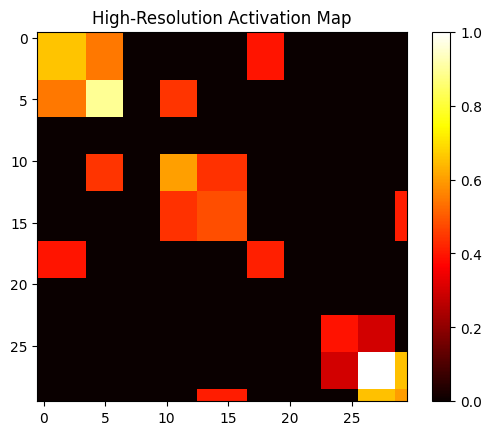

In [74]:
def high_resolution_refinement(raw, low_res_map, refinement_factor=3, threshold_multiplier=1.0):
    """
    Refine the low-resolution map to achieve higher resolution.

    Parameters:
        raw (Raw): Preprocessed EEG data.
        low_res_map (np.ndarray): Low-resolution activation map.
        refinement_factor (int): Factor to refine grid resolution.
        threshold_multiplier (float): Multiplier for dynamic threshold calculation.

    Returns:
        np.ndarray: Refined high-resolution activation map.
    """
    # Calculate threshold dynamically
    threshold = np.mean(low_res_map) + threshold_multiplier * np.std(low_res_map)
    print(f"Dynamic Threshold: {threshold}")

    # Define high-resolution grid dimensions
    low_res_shape = low_res_map.shape
    high_res_size = low_res_shape[0] * refinement_factor
    high_res_map = np.zeros((high_res_size, high_res_size))

    # Generate grid coordinates for high-resolution map
    high_res_grid_x = np.linspace(0, low_res_shape[0] - 1, high_res_size)
    high_res_grid_y = np.linspace(0, low_res_shape[1] - 1, high_res_size)

    print(f"High-res grid size: {high_res_size}x{high_res_size}")

    # Refinement process: Loop through high-resolution grid
    for i, x in enumerate(high_res_grid_x):
        for j, y in enumerate(high_res_grid_y):
            # Map high-resolution indices to low-resolution indices
            low_res_i = int(x)  # Floor value of x
            low_res_j = int(y)  # Floor value of y
            low_res_value = low_res_map[low_res_i, low_res_j]

            # Debug: Display low-resolution value
            print(f"Low-res value at ({low_res_i}, {low_res_j}): {low_res_value}")

            # Process points that pass the threshold
            if low_res_value > threshold:
                print(f"Point ({x:.2f}, {y:.2f}) passed threshold with low-res value: {low_res_value}")
                activation = compute_activation_at_point(raw, x, y)
                print(f"Computed activation: {activation}")

                # Update high-resolution map with activation weighted by low-res value
                high_res_map[i, j] = activation * low_res_value

    # Debug: Display statistics of the high-resolution map before normalization
    print(f"High-res map statistics before normalization: min={np.min(high_res_map)}, max={np.max(high_res_map)}")

    # Normalize the high-resolution map for visualization
    min_val, max_val = np.min(high_res_map), np.max(high_res_map)
    if max_val != min_val:
        high_res_map = (high_res_map - min_val) / (max_val - min_val)
    else:
        print("High-res map is uniform; skipping normalization.")

    return high_res_map

# Generate and visualize high-resolution map
high_res_map = high_resolution_refinement(raw, low_res_map, refinement_factor=3, threshold_multiplier=0.75)
plt.imshow(high_res_map, cmap="hot", vmin=0, vmax=1)
plt.title("High-Resolution Activation Map")
plt.colorbar()
plt.show()

#### Why Identify Neural Silence?
Neural silence provides valuable insights into how the brain transitions between active and resting states. It can inform studies on:
- Cognitive load and mental relaxation.
- Neural inhibition and suppression mechanisms.
- Restorative brain functions during moments of inactivity.

#### 7.3 Validation and Evaluation of SilenceMap Algorithm

We now evaluate the SilenceMap algorithm using the following steps: 
1. **Quantitative Metrics Calculation** (MSE, Precision, Recall, F1-score)
2. **Dynamic Threshold Analysis** (how threshold multiplier and refinement factor impacts activation maps and classification)
3. **Visual Comparison of Activation Maps** (Low vs High Resolution Maps, Ground Truth Map Alignment)
4. **Cross-Dataset Validation**

##### 7.3.1 Quantitative Metrics Calculation

- **Mean Squared Error (MSE)**: Measures the average squared difference between the predicted and ground truth activation maps.
- **Precision, Recall, and F1-Score**: Evaluates the binary classification performance of the SilenceMap on neural silences.

In [6]:
# import numpy as np
# from sklearn.metrics import mean_squared_error, precision_recall_fscore_support
# import matplotlib.pyplot as plt

# # Function to calculate quantitative metrics
# def evaluate_silencemap(ground_truth_map, predicted_map, threshold_multiplier, refinement_factor):
#     """
#     Evaluate the SilenceMap algorithm's output.

#     Parameters:
#         ground_truth_map (np.ndarray): Ground truth activation map.
#         predicted_map (np.ndarray): Predicted activation map from SilenceMap.
#         threshold_multiplier (float): Multiplier used for dynamic thresholding.
#         refinement_factor (int): Refinement factor used in high-resolution refinement.

#     Returns:
#         dict: Evaluation metrics including MSE, Precision, Recall, and F1-Score.
#     """
#     # Flatten maps for comparison
#     gt_flat = ground_truth_map.flatten()
#     pred_flat = predicted_map.flatten()

#     # Calculate Mean Squared Error (MSE)
#     mse = mean_squared_error(gt_flat, pred_flat)

#     # Convert predicted map to binary using the threshold
#     threshold = np.mean(pred_flat) + threshold_multiplier * np.std(pred_flat)
#     pred_binary = (pred_flat > threshold).astype(int)
#     gt_binary = (gt_flat > threshold).astype(int)

#     # Calculate Precision, Recall, and F1-Score
#     precision, recall, f1_score, _ = precision_recall_fscore_support(gt_binary, pred_binary, average='binary')

#     # Return evaluation metrics
#     metrics = {
#         "MSE": mse,
#         "Precision": precision,
#         "Recall": recall,
#         "F1-Score": f1_score,
#         "Threshold Multiplier": threshold_multiplier,
#         "Refinement Factor": refinement_factor
#     }
#     return metrics

# # Function to visualize high-resolution vs. low-resolution maps
# def visualize_comparison(low_res_map, high_res_map, ground_truth_map=None):
#     """
#     Visualize and compare the activation maps.

#     Parameters:
#         low_res_map (np.ndarray): Low-resolution activation map.
#         high_res_map (np.ndarray): High-resolution activation map.
#         ground_truth_map (np.ndarray, optional): Ground truth map for comparison.
#     """
#     plt.figure(figsize=(15, 5))

#     # Plot low-resolution map
#     plt.subplot(1, 3, 1)
#     plt.imshow(low_res_map, cmap="hot", vmin=0, vmax=1)
#     plt.title("Low-Resolution Activation Map")
#     plt.colorbar()

#     # Plot high-resolution map
#     plt.subplot(1, 3, 2)
#     plt.imshow(high_res_map, cmap="hot", vmin=0, vmax=1)
#     plt.title("High-Resolution Activation Map")
#     plt.colorbar()

#     # Plot ground truth map (if available)
#     if ground_truth_map is not None:
#         plt.subplot(1, 3, 3)
#         plt.imshow(ground_truth_map, cmap="hot", vmin=0, vmax=1)
#         plt.title("Ground Truth Activation Map")
#         plt.colorbar()

#     plt.show()

# # Cross-dataset testing function
# def test_on_multiple_datasets(datasets, silence_map_func, refinement_factor, threshold_multiplier):
#     """
#     Test the SilenceMap algorithm on multiple datasets.

#     Parameters:
#         datasets (list): List of (raw_data, ground_truth_map) tuples for testing.
#         silence_map_func (function): SilenceMap function to generate activation maps.
#         refinement_factor (int): Refinement factor for high-resolution refinement.
#         threshold_multiplier (float): Multiplier for dynamic thresholding.

#     Returns:
#         dict: Aggregated results for all datasets.
#     """
#     all_metrics = []
#     for idx, (raw, ground_truth_map) in enumerate(datasets):
#         print(f"Testing on dataset {idx + 1}/{len(datasets)}...")
        
#         # Generate low-resolution map
#         low_res_map = low_resolution_initialization(raw)
        
#         # Generate high-resolution map
#         high_res_map = silence_map_func(raw, low_res_map, refinement_factor, threshold_multiplier)
        
#         # Evaluate the results
#         metrics = evaluate_silencemap(ground_truth_map, high_res_map, threshold_multiplier, refinement_factor)
#         print(f"Metrics for dataset {idx + 1}: {metrics}")
        
#         all_metrics.append(metrics)
        
#         # Visualize comparison
#         visualize_comparison(low_res_map, high_res_map, ground_truth_map)
    
#     return all_metrics

# # # Replace with your preprocessed EEG data (raw/epochs) and ground truth activation maps
# # real_datasets = [
# #     (raw.get_data(), ground_truth_map_1),  # Dataset 1 with ground truth map
# #     (raw.get_data(), ground_truth_map_2)   # Dataset 2 with ground truth map
# # ]



In [7]:
# raw.get_data()

In [5]:
# np.shape(lesion_mask)

In [4]:
# inverse_operator

In [1]:
# import numpy as np
# from scipy.ndimage import zoom

# # Example lesion mask (256x256x256)
# lesion_mask = np.random.randint(0, 2, (256, 256, 256), dtype=bool)

# # Step 1: Create a 2D projection (e.g., maximum intensity projection along the z-axis)
# ground_truth_2d = np.max(lesion_mask, axis=2).astype(float)

# # Step 2: Downsample to match SilenceMap resolution (e.g., 50x50)
# target_shape = (50, 50)
# downsampled_ground_truth = zoom(ground_truth_2d, (target_shape[0] / ground_truth_2d.shape[0],
#                                                   target_shape[1] / ground_truth_2d.shape[1]))

# # Normalize the map to ensure values are 0 or 1
# downsampled_ground_truth = (downsampled_ground_truth > 0.5).astype(float)

# # Replace in dataset
# real_datasets = [
#     (raw.get_data(), downsampled_ground_truth),  # Dataset 1
#     (raw.get_data(), downsampled_ground_truth)   # Dataset 2 (if the same map is reused)
# ]


In [2]:
# # Pass these real datasets to the test function
# results = test_on_multiple_datasets(real_datasets, high_resolution_refinement, refinement_factor=3, threshold_multiplier=1.0)
# print("Aggregated Results:", results)

In [3]:
# real_datasets